In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):

    max_depth = trial.suggest_int('max_depth', 100, 3000)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 300)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 300)

    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize') 
improvement_threshold = 0.001
stale_count = 0

best_mse = float('inf')

mse_values = []

for _ in range(2000):
    study.optimize(objective, n_trials=1)

    if study.best_value < best_mse:
        best_mse = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    mse_values.append(best_mse)

    if stale_count >= 1600 or best_mse <= improvement_threshold:  
        break

best_params = study.best_params
best_mse = study.best_value

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)



[I 2023-11-15 10:08:12,847] A new study created in memory with name: no-name-6c22caa3-5c41-4f8c-b748-c80d04c715ee
[I 2023-11-15 10:08:12,860] Trial 0 finished with value: 356.45035066954506 and parameters: {'max_depth': 388, 'min_samples_split': 130, 'min_samples_leaf': 190}. Best is trial 0 with value: 356.45035066954506.
[I 2023-11-15 10:08:12,867] Trial 1 finished with value: 341.29191982148035 and parameters: {'max_depth': 2812, 'min_samples_split': 289, 'min_samples_leaf': 292}. Best is trial 1 with value: 341.29191982148035.
[I 2023-11-15 10:08:12,877] Trial 2 finished with value: 340.55767850364185 and parameters: {'max_depth': 2344, 'min_samples_split': 199, 'min_samples_leaf': 66}. Best is trial 2 with value: 340.55767850364185.
[I 2023-11-15 10:08:12,887] Trial 3 finished with value: 360.8977620433334 and parameters: {'max_depth': 1914, 'min_samples_split': 20, 'min_samples_leaf': 156}. Best is trial 2 with value: 340.55767850364185.
[I 2023-11-15 10:08:12,887] Trial 4 finish

KeyboardInterrupt: 

Średni błąd kwadratowy (MSE): 271.20476655106245
Procentowa zgodność: -66.81%


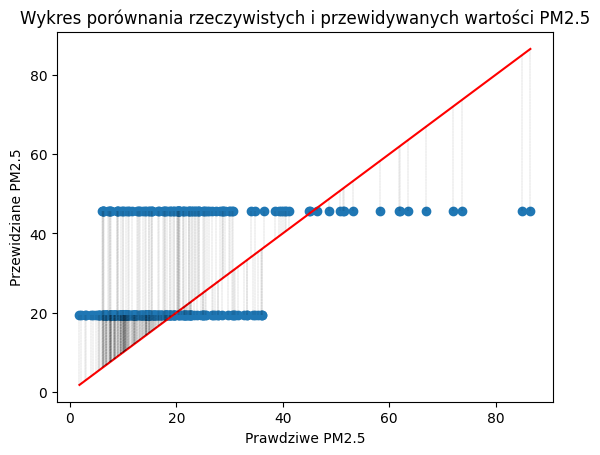

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
255,19.50,19.508861,0.008861
27,19.54,19.508861,0.031139
258,19.60,19.508861,0.091139
338,19.70,19.508861,0.191139
9,19.29,19.508861,0.218861
...,...,...,...
199,6.30,45.722480,39.422480
164,6.30,45.722480,39.422480
63,6.17,45.722480,39.552480
177,6.00,45.722480,39.722480


In [8]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


model = DecisionTreeRegressor(**best_params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')
